# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [212]:
import io
import os
import numpy as np
import scipy

In [213]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        lk = list(self.word2vec.keys())
        ls = [-1. * self.score(wc, w) for wc in lk]
        args = np.argsort(ls)[:K]
        words = [lk[a] for a in args]
        lk = []
        return words

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        vw1, vw2 = self.word2vec[w1], self.word2vec[w2]
        return np.dot(vw1, vw2) / (np.linalg.norm(vw1)*np.linalg.norm(vw2))


In [69]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-2M.vec'), nmax=100000) #25000
# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.6716836662792491
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'london', 'berlin']
['germany', 'austria', 'europe', 'german', 'berlin']


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors -> list
                try:
                    emb = np.average([self.w2v.word2vec[w] for w in set(sent) if w in self.w2v.word2vec],
                                     weights = [1. for w in set(sent) if w in self.w2v.word2vec], axis = 0)
                except Exception:
                    emb = np.zeros(300)
            else:
                # idf-weighted mean of word vectors
                try:
                    emb = np.average([self.w2v.word2vec[w] for w in set(sent) if w in self.w2v.word2vec],
                                 weights = [idf[w] for w in set(sent) if w in self.w2v.word2vec], axis = 0)
                except Exception:
                    emb = np.zeros(300)
            sentemb.append(emb)
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)[0]
        ls = []
        for i in range(len(sentences)):
            ls.append(-1. * self.score(query, keys[i], encoded = True))
        args = np.argsort(ls)[:K]
        words = [sentences[a] for a in args]
        # Pretty print
        print('query', " ".join(s))
        for j in range(K):
            print(str(j), " ".join(words[j]) )
        return words

    def score(self, s1, s2, idf=False, encoded = False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        if not encoded:
            s1, s2 = self.encode([s1], idf)[0], self.encode([s2], idf)[0]
        return np.dot(s1, s2) / (np.linalg.norm(s1)*np.linalg.norm(s2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf

In [71]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-2M.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with io.open(PATH_TO_DATA+"sentences.txt", encoding='utf-8') as f:
    for i, line in enumerate(f):
        sentences.append(line.split(' '))
        
# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors


/Users/eloise/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


query 1 smiling african american boy . 

0 1 smiling african american boy . 

1 blond boy waterskiing . 

2 a boy blowing bubbles . 

3 a boy surfs . 

4 a boy dunks a basketball . 

0.5926775053017799
query 1 smiling african american boy . 

0 1 smiling african american boy . 

1 a man rides a 4 wheeler in the desert . 

2 5 women and 1 man are smiling for the camera . 

3 3 males and 1 woman enjoying a sporting event 

4 a man in black is juggling 3 flamed bottles . 

0.5354923843214625


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [76]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

def fill_dict(fname, nmax):
    ldict = {}
    with io.open(fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            ldict[word] = np.fromstring(vec, sep=' ')
            if i == (nmax - 1):
                break
    return ldict

nmax = 50000
french = fill_dict('./data/wiki.fr.vec', nmax)
english = fill_dict('./data/wiki.en.vec', nmax)

In [77]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

X, Y = [], []

for wk in english.keys():
    if wk in french.keys():
        X.append(french[wk])
        Y.append(english[wk])
        
X = np.array(X).T
Y = np.array(Y).T

In [78]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
import scipy.linalg

U, s, Vh = scipy.linalg.svd(Y.dot(X.T))
W = U.dot(Vh)

In [79]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def sim(w1, w2):
    return np.dot(w1, w2) / (np.linalg.norm(w1)*np.linalg.norm(w2))

def find_eng_nn(fw, W):
    aligned = W.dot(french[fw].reshape(-1, 1)).reshape((-1,))
    ew = list(english.keys())
    dists = [-1 * sim(aligned, english[e]) for e in ew]
    ags = np.argsort(dists)
    word = ew[ags[0]]
    ew = []
    return word

def find_fr_nn(fw, W):
    aligned = np.linalg.inv(W).dot(english[fw].reshape(-1, 1)).reshape((-1,))
    ew = list(french.keys())
    dists = [-1 * sim(aligned, french[e]) for e in ew]
    ags = np.argsort(dists)
    word = ew[ags[0]]
    ew = []
    return word
    
print('>> french to english <<')
for fw in ('chat', 'chapeau', 'pont', 'sourire', 'soleil', 'surprise', 'tente', 'diplôme'):
    print(fw, find_eng_nn(fw, W))
print('')
print('>> english to french <<')
for fw in ('damp', 'birthday', 'sick', 'foul', 'silent', 'sound', 'acre', 'soil'):
    print(fw, find_fr_nn(fw, W))

>> french to english <<
chat cat
chapeau handkerchief
pont bridge
sourire amuse
soleil sun
surprise surprise
tente persuade
diplôme diploma

>> english to french <<
damp humide
birthday anniversaire
sick malades
foul adverses
silent muet
sound sonore
acre acres
soil sols


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [214]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_SST(fname, labels = True):
    X, Y = [], []
    if labels:
        with io.open(fname, encoding='utf-8') as f:
            for i, line in enumerate(f):
                score, sent = line.split(' ', 1)
                X.append(sent.split(' '))
                Y.append(int(score))
        Y = np.array(Y)
        return X, Y
    else:
        with io.open(fname, encoding='utf-8') as f:
            for i, line in enumerate(f):
                X.append(line.split(' '))
        return X
    
X_train, Y_train = load_SST('./data/SST/stsa.fine.train')
X_dev, Y_dev = load_SST('./data/SST/stsa.fine.dev')
X_test = load_SST('./data/SST/stsa.fine.test.X', labels = False)

In [215]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-2M.vec'), nmax=25000)
s2v = BoV(w2v)

X_train_f = s2v.encode(X_train, idf=False)
X_dev_f = s2v.encode(X_dev, idf=False)
X_test_f = s2v.encode(X_test, idf=False)
X_train_t = s2v.encode(X_train, idf=s2v.build_idf(X_train))
X_dev_t = s2v.encode(X_dev, idf=s2v.build_idf(X_dev))
X_test_t = s2v.encode(X_test, idf=s2v.build_idf(X_test))

Loaded 25000 pretrained word vectors


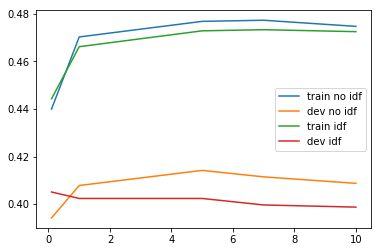

In [218]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

C_list = [0.1, 1., 5., 7., 10.]
train_f = []
dev_f = []
train_t = []
dev_t = []
for C in C_list:
    model = LogisticRegression(penalty='l2', C=C, 
                               class_weight=None, random_state=None,
                               max_iter=100, multi_class='multinomial', verbose=0,
                               warm_start=False, n_jobs=None, solver = 'newton-cg')
    model.fit(X_train_f, Y_train)
    train_f.append(model.score(X_train_f, Y_train))
    dev_f.append(model.score(X_dev_f, Y_dev))
        
    model = LogisticRegression(penalty='l2', C=C, 
                               class_weight=None, random_state=None,
                               max_iter=100, multi_class='multinomial', verbose=0,
                               warm_start=False, n_jobs=None, solver = 'newton-cg')
    model.fit(X_train_t, Y_train)
    train_t.append(model.score(X_train_t, Y_train))
    dev_t.append(model.score(X_dev_t, Y_dev))

C = C_list[np.argmax(dev_f)]
model = LogisticRegression(penalty='l2', C=C, 
                               class_weight=None, random_state=None,
                               max_iter=100, multi_class='multinomial', verbose=0,
                               warm_start=False, n_jobs=None, solver = 'newton-cg')
model.fit(X_train_f, Y_train)

plt.figure()
plt.plot(C_list, train_f)
plt.plot(C_list, dev_f)
plt.plot(C_list, train_t)
plt.plot(C_list, dev_t)
plt.legend(['train no idf', 'dev no idf', 'train idf', 'dev idf'])
plt.show()

In [219]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

Y_test = model.predict(X_test_f)

outname = "logreg_bov_y_test_sst.txt"
if os.path.exists(outname): 
    os.remove(outname)
file = open(outname, "w")
for y in Y_test:
    file.write(str(y)+'\n')
file.close() 

! wc -l logreg_bov_y_test_sst.txt

    2210 logreg_bov_y_test_sst.txt


In [220]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

model_f = LinearSVC(C=1., penalty='l2', loss='squared_hinge')

model_f.fit(X_train_f, Y_train)
print(model_f.score(X_train_f, Y_train))
print(model_f.score(X_dev_f, Y_dev))

model_t = LinearSVC(C=1., penalty='l2', loss='squared_hinge')

model_t.fit(X_train_t, Y_train)
print(model_t.score(X_train_t, Y_train))
print(model_t.score(X_dev_t, Y_dev))

Y_test = model_t.predict(X_test_t)

outname = "svc_bov_y_test_sst.txt"
if os.path.exists(outname): 
    os.remove(outname)
file = open(outname, "w")
for y in Y_test:
    file.write(str(y)+'\n')
file.close() 

! wc -l svc_bov_y_test_sst.txt

0.47073970037453183
0.39872842870118075
0.46629213483146065
0.40054495912806537
    2210 svc_bov_y_test_sst.txt


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [5]:
import keras

Using TensorFlow backend.
/Users/eloise/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [115]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/SST"

def load_SST_to_string(fname, labels = True):
    X, Y = [], []
    if labels:
        with io.open(fname, encoding='utf-8') as f:
            for i, line in enumerate(f):
                score, sent = line.split(' ', 1)
                X.append(sent)
                Y.append(int(score))
        Y = np.array(Y)
        return X, Y
    else:
        with io.open(fname, encoding='utf-8') as f:
            for i, line in enumerate(f):
                X.append(line)
        return X

X_train, Y_train = load_SST_to_string('./data/SST/stsa.fine.train')
X_dev, Y_dev = load_SST_to_string('./data/SST/stsa.fine.dev')
X_test = load_SST_to_string('./data/SST/stsa.fine.test.X', labels = False)

In [116]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
from keras.preprocessing.text import one_hot
#     https://keras.io/preprocessing/text/

def one_hot_process(X):
    Xh = []
    for x in X:
        Xh.append(one_hot(x, 5000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' '))
    return Xh

X_train = one_hot_process(X_train)
X_dev = one_hot_process(X_dev)
X_test = one_hot_process(X_test)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y_train = enc.fit_transform(Y_train.reshape(-1, 1))
Y_dev = enc.transform(Y_dev.reshape(-1, 1))

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [117]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
from keras.preprocessing.sequence import pad_sequences
#     https://keras.io/preprocessing/sequence/

X_train = pad_sequences(X_train, maxlen=50, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_dev = pad_sequences(X_dev, maxlen=50, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_test = pad_sequences(X_test, maxlen=50, dtype='int32', padding='pre', truncating='pre', value=0.0)

## 4.2 - Design and train your model

In [118]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

from keras import backend as K
K.set_learning_phase(1)

embed_dim  = 32 # 32  # word embedding dimension
nhid       = 64 # 64 # number of hidden units in the LSTM
vocab_size = 5000 # 1000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.3, recurrent_dropout=0.3)) #0.2 0.2
model.add(Dense(n_classes, activation='sigmoid'))


In [119]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 32)          160000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 325       
Total params: 185,157
Trainable params: 185,157
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 4 #6

history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, Y_dev))

## ADD Tensorboard logs

Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8544/8544 [==============================] - 15s 2ms/step - loss: 1.5747 - acc: 0.2720 - val_loss: 1.5697 - val_acc: 0.2534
Epoch 2/4
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5372 - acc: 0.3006 - val_loss: 1.4933 - val_acc: 0.3379
Epoch 3/4
8544/8544 [==============================] - 10s 1ms/step - loss: 1.3878 - acc: 0.3820 - val_loss: 1.4260 - val_acc: 0.3606
Epoch 4/4
8544/8544 [==============================] - 10s 1ms/step - loss: 1.2426 - acc: 0.4247 - val_loss: 1.4442 - val_acc: 0.3697


In [121]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis = 1)

outname = "logreg_lstm_y_test_sst.txt"
if os.path.exists(outname): 
    os.remove(outname)
file = open(outname, "w")
for y in Y_test:
    file.write(str(y)+'\n')
file.close() 

! wc -l logreg_lstm_y_test_sst.txt

    2210 logreg_lstm_y_test_sst.txt


## 4.3 -- innovate !

In [206]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

model = Sequential()
model.add(Embedding(5000, 32, input_length=50))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))


In [207]:
loss_classif     =  'categorical_crossentropy'
optimizer        =  'adam'
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 50, 32)            160000    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 250)               200250    
_________________________________________________________________
dense_77 (Dense)             (None, 5)                 1255      
Total params: 364,609
Trainable params: 364,609
Non-trainable params: 0
_________________________________________________________________
None

In [208]:
bs = 64
n_epochs = 2

history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, Y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/2
8544/8544 [==============================] - 7s 821us/step - loss: 1.5700 - acc: 0.2735 - val_loss: 1.5672 - val_acc: 0.2752
Epoch 2/2
8544/8544 [==============================] - 2s 213us/step - loss: 1.4358 - acc: 0.3904 - val_loss: 1.4135 - val_acc: 0.3942


In [209]:
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis = 1)

outname = "logreg_conv1d_y_test_sst.txt"
if os.path.exists(outname): 
    os.remove(outname)
file = open(outname, "w")
for y in Y_test:
    file.write(str(y)+'\n')
file.close() 

! wc -l logreg_conv1d_y_test_sst.txt

    2210 logreg_conv1d_y_test_sst.txt
